In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import matplotlib.pyplot as plt
%matplotlib inline

# Inverse RL with linear MDP
-assuming that the state transitions can be approximated as a linear control process and we observe the trajectory generated from an optimal policy, then the inverse problem is a MLE problem that finds the corresponding value function
-will apply this method to a 1D drift-diffusion process, where the diffusion is an environmental passive process and the drift corresponds to value ("free-energy potential")

Here's the net reward at each given state when the KL control cost (entropy term) is considered:

$R(s,\pi) = q(s) - KL(p||\pi)$

The objective function, in terms of RL, would be the maximized expected reward (or min-cost depending on the setup):

$V(s) = E[\Sigma_t R(s,\pi) | s_t = s]$

The key assumption is that the control protocol in LMDP is: $\pi(s'|s;u) = p(s'|s) exp(u)$, then solving for $v(s) = max{R(s,u)+\Sigma \pi(s'|s'u)V(s')}$ gives us optimal policy that looks like Boltzmann:

$\pi^*(s'|s) = \frac{1}{Z} p(s'|s)exp(V(s'))$

where Z is the partition function, or the "desirbility" function in terms of LMDP. Solve for minimizing the negative log-likelihood $L[V(.)]$ is the inverse RL problem.

## Build model

Text(0, 0.5, 'value')

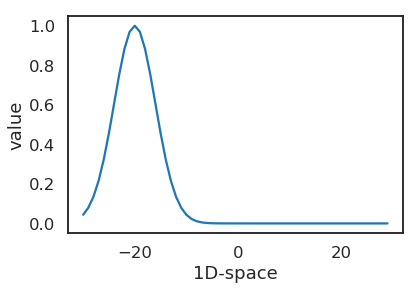

In [2]:
#value function
xx = np.arange(-30,30,1)  #1-D grid
mu = -20  #target
sig = 4.  #uncertenty
V = np.exp(-(xx-mu)**2/(2*sig**2))  #value/energy function

plt.plot(xx,V)
plt.xlabel('1D-space')
plt.ylabel('value')

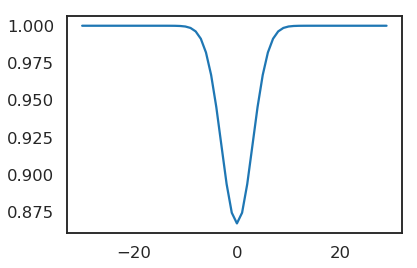

In [3]:
#"passive-value" from diffusive dynamics
ini = 0
DD = 3
diffu = np.exp(-(xx-ini)**2/(2*DD**2))
diffu = 1-diffu/diffu.sum()
plt.plot(xx,diffu)

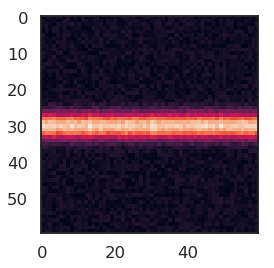

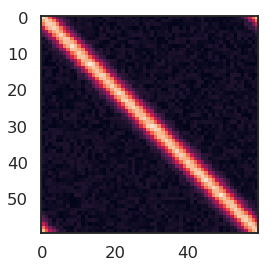

In [28]:
#environment transition
ini = 0
inip = np.where(xx==ini)[0][0]
DD = 2.5
diffu = np.exp(-(xx-ini)**2/(2*DD**2))
#diffu = (1-diffu)*5. #/diffu.sum()
temp = np.random.rand(len(xx),len(xx)) + 10*diffu.T #np.arange(len(x))
pss = temp.T/temp.sum(1)
plt.imshow(pss)

#transition matrix
M = np.zeros_like(pss)
for ii in range(0,M.shape[0]):
    M[ii,:] = np.roll(pss[:,ii],ii-inip)  #to algin on the diagonal

M = M/np.sum(M,axis=1)   
plt.figure()
plt.imshow(M)  #with periodic boundary...

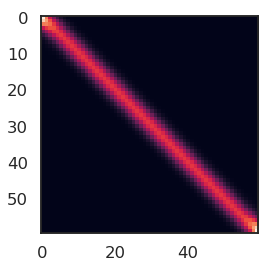

In [29]:
#transition matrix
def Gaussian_diag(x,ini,D):
    """
    input vector x as a grid, the center position, and D as the variance of the kernel
    """
    dia = np.exp(-(x-ini)**2/(2*DD**2))
    return dia
M = np.zeros_like(pss)
for ii in range(0,M.shape[0]):
    M[ii,:] = Gaussian_diag(xx,xx[ii],DD)  #to algin on the diagonal

M = M/np.sum(M,axis=1)    
plt.imshow(M)  #with periodic boundary...

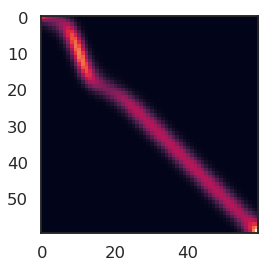

In [30]:
###compute the optimal policy given value
beta = 4.5 ##inverse temperature!
pol = np.zeros_like(pss)
for s1 in range(0,len(xx)):
    numer = np.zeros(len(xx))
    for s2 in range(0,len(xx)):
        numer[s2] = M[s1,s2]*np.exp(beta*(V[s2]))# + v[s2]*np.log(v[s2]/pss[s2,s1])))
    denom = np.sum(numer)
    pol[s1,:] = numer/denom
    
plt.imshow(pol,interpolation='none')

## Generate trajectories

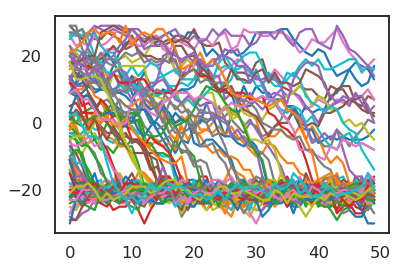

In [31]:
###iteration from policy
rep = 100
tt = 50
trackx = np.zeros((rep,tt))

for r in range(0,rep):
    track = np.zeros(tt)
    track[0] = int(np.random.randint(len(xx))) #inip   #use index in this recording
    trackx[r,0] = xx[int(track[0])]  #use value according to the coordinate in this recording
    for t in range(0,tt-1):
        sumprob = np.cumsum(pol[int(track[t]),:])
        nextstep = np.argmin(np.abs(np.random.rand()-sumprob))
        track[t+1] = nextstep
        
        ### boundary conditions
        if track[t+1]>=len(xx) or track[t+1]<0:
            track[t+1] = track[t]
            
        trackx[r,t+1] = xx[int(track[t+1])]
        
plt.plot(trackx.T);

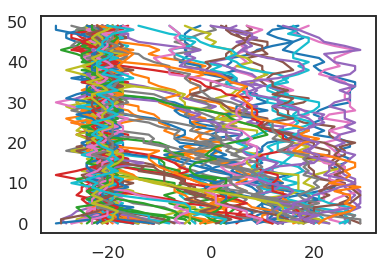

In [40]:
for ii in range(rep):
    plt.plot((trackx[ii,:]),np.arange(0,tt));#np.flip

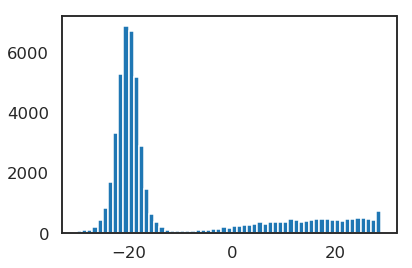

In [10]:
#density
plt.hist(np.ravel(trackx).T,bins = xx);

## Reconstruction

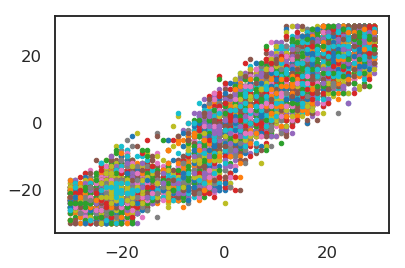

In [11]:
temp_p = []
temp_f = []
for r in range(0,rep):
    temp = trackx[r,:]
    plt.plot(temp[:-1],temp[1:],'.')

    temp_p = np.concatenate([temp_p,temp[:-1]],axis=0)
    temp_f = np.concatenate([temp_f,temp[1:]],axis=0)

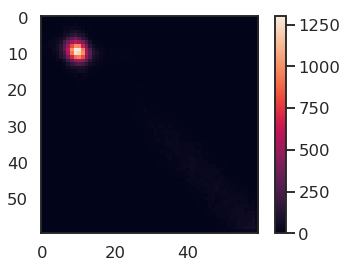

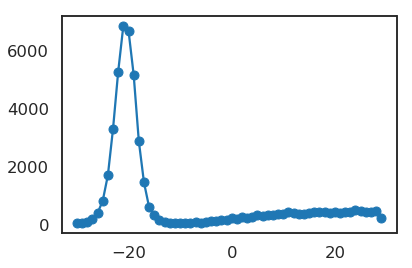

In [12]:
#joint and marginal distribution
joint, xedges, yedges = np.histogram2d(temp_p, temp_f, bins = np.append(xx,xx[-1]+1))#len(np.unique(temp_p)))  #len(x)
plt.imshow(joint.T,interpolation='none')
plt.colorbar()
margin_p, edges = np.histogram(temp_p, bins = np.append(xx,xx[-1]+1))#len(np.unique(temp_p)))
margin_f, edges = np.histogram(temp_f, bins = np.append(xx,xx[-1]+1))#len(np.unique(temp_p)))
plt.figure()
plt.plot(edges[:-1],margin_f,'-o')

In [13]:
#avoid dividing zeros
joint[joint==0] = 1
margin_p[margin_p==0] = 1
margin_f[margin_f==0] = 1

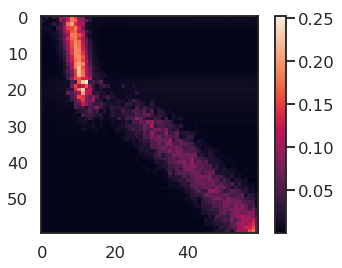

In [14]:
#conditional distribution
trans = (joint.T/margin_p).T#jointProbs/margin
trans = trans/np.sum(trans,axis=1)
plt.imshow(trans,interpolation='none')
plt.colorbar()

## Inverse RL

In [15]:
# def nLL(val,trans):
#     """
#     negative log-likelihood for value function
#     input vector for values and transition matrix
#     """
#     aa = -np.sum(np.log(val))
#     bb = np.sum(np.log(trans @ val))
#     return aa + bb

def nLL_val(val,pss,lamb,margin_f,margin_p):
    """
    negative log-likelihood for value function
    input vector for values to be optimized, pss for transition matrix,
    lambda regularization, marginal distribution for future and past over states
    """
    aa = -np.sum(val*margin_f)
    expv = np.exp(val)
    bb = np.sum( np.log( (pss @ expv) ) *margin_p)
    cc = lamb*np.sum(np.diff(val)**2)  #smoothness regularization
    return aa + bb + cc

In [16]:
from scipy.optimize import minimize
x0 = np.random.rand(trans.shape[0])
res = minimize(nLL_val, x0, args=(M,10,margin_f,margin_p))#, tol=1e-6)

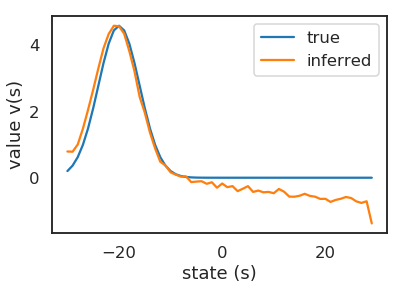

In [23]:
V_est = res.x
plt.plot(xx,V/max(V)*max(V_est),'-',label='true')
plt.plot(xx,V_est,label='inferred')
plt.xlabel('state (s)')
plt.ylabel('value v(s)')
plt.legend()